#### Imports

In [1]:
import os
from PIL import Image
import pandas as pd
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import warnings
from torch.utils.data import random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report
from torchvision import transforms
from torch.utils.data import  Subset

warnings.filterwarnings('ignore')


### Device Setting

In [2]:
if torch.cuda.is_available():

    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")

    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is available with 1 device(s).
Current GPU: NVIDIA GeForce GTX 1650


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

#### Dataset class

In [4]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, f"{self.df['unique_id'].iloc[idx]}.jpg")
        image = Image.open(img_name).convert('RGB')

        # Regression targets
        regression_targets = torch.tensor([self.df['loss_percentage'].iloc[idx], self.df['irradiance_level'].iloc[idx]], dtype=torch.float32)

        # Classification target
        classification_target = torch.tensor(self.df['type_soil'].iloc[idx], dtype=torch.long)  # type_soil is integer-encoded

        if self.transform:
            image = self.transform(image)

        return image, {'regression': regression_targets, 'classification': classification_target}

In [5]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Augmentation techniques

 - Augmentation applied to the training images;
 - Random flip to add robustness to images that can be taken with other cameras;
 - Gaussian blur for pictures that can be taken in a hurry and have some lower resolution;
 - Random flip and rotation to become robust to different angles
 - Random noise to mimic potential noise that can come from multiple sources in real worl environment

In [23]:
# Augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.RandomHorizontalFlip(p=0.10),
    transforms.RandomVerticalFlip(10),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Load data

In [7]:
custom_dataset = CustomDataset(csv_file='final_df.csv', img_folder='SolarPanelSoilingImageDataset\Pytorch_data\ID/', transform=transform)

dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)


### Visualize the loaded data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

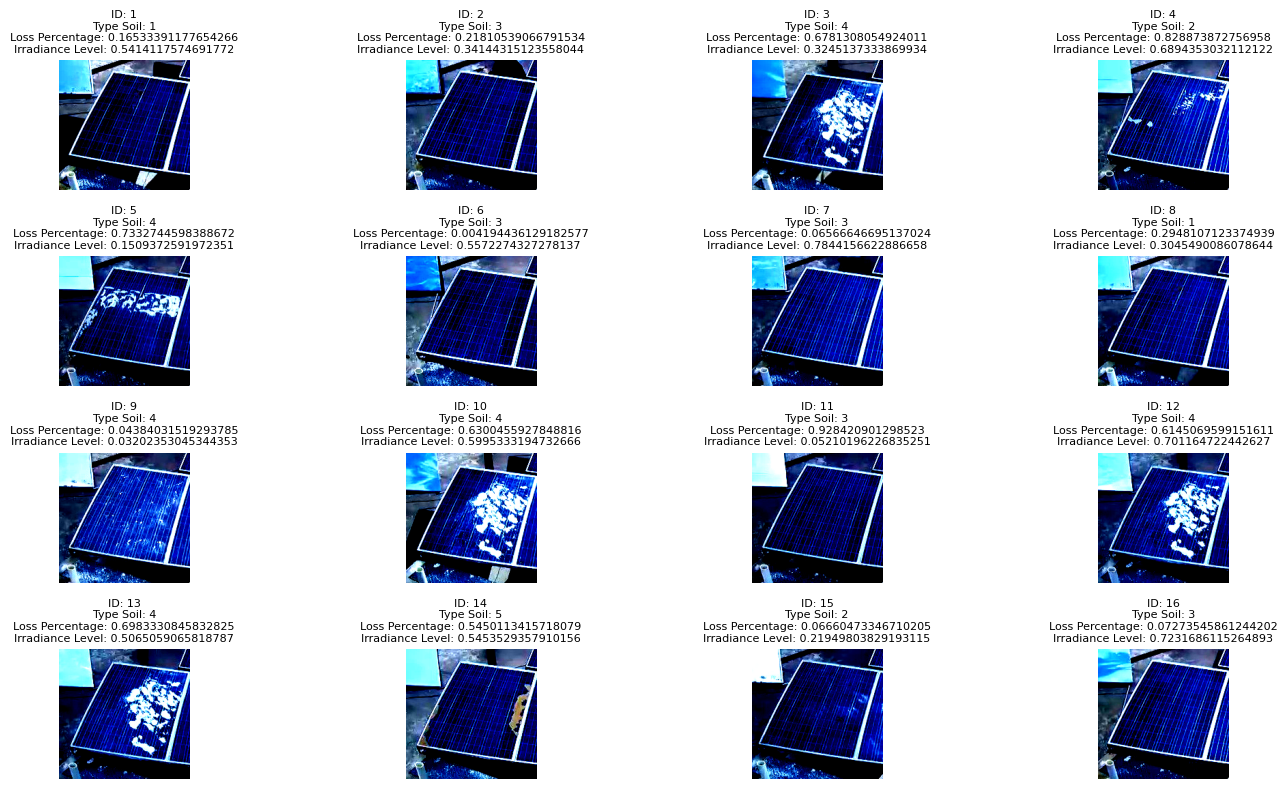

In [8]:
images, targets = next(iter(dataloader))

np_images = images.numpy()

num_rows = 4
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes = axes.flatten()

for i in range(num_rows * num_cols):
    image = np.transpose(np_images[i], (1, 2, 0))
    regression_targets = targets['regression'][i].numpy()
    classification_target = targets['classification'][i].item()
    image_id = custom_dataset.df['unique_id'].iloc[i]

    axes[i].imshow(image)
    axes[i].set_title(f'ID: {image_id}\nType Soil: {classification_target}\nLoss Percentage: {regression_targets[0]}\nIrradiance Level: {regression_targets[1]}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Train Test Split


In [9]:
train_size = int(0.7 * len(custom_dataset))
validation_size = int(0.2 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - validation_size

# Use random_split to split the dataset
train_dataset, validation_dataset, test_dataset = random_split(custom_dataset, [train_size, validation_size, test_size])

# Create DataLoader for each split
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
sample = next(iter(dataloader))

input_image, target = sample

print("Input image dimensions:", input_image.shape)
print("Target value:", target)

Input image dimensions: torch.Size([32, 3, 192, 192])
Target value: {'regression': tensor([[0.8169, 0.2694],
        [0.6180, 0.7536],
        [0.7899, 0.2912],
        [0.3166, 0.1987],
        [0.0153, 0.6405],
        [0.8149, 0.5952],
        [0.3880, 0.1212],
        [0.0028, 0.0836],
        [0.9445, 0.5748],
        [0.6216, 0.6701],
        [0.1928, 0.7939],
        [0.4201, 0.2624],
        [0.1614, 0.4104],
        [0.4828, 0.3989],
        [0.2220, 0.5923],
        [0.1789, 0.7544],
        [0.3041, 0.1100],
        [0.3118, 0.6286],
        [0.2169, 0.5496],
        [0.5992, 0.0251],
        [0.3468, 0.1194],
        [0.8025, 0.4376],
        [0.6847, 0.3897],
        [0.6326, 0.5628],
        [0.5418, 0.3596],
        [0.4139, 0.5219],
        [0.6500, 0.0577],
        [0.5330, 0.3718],
        [0.1572, 0.4884],
        [0.8999, 0.3542],
        [0.4979, 0.2944],
        [0.5213, 0.3602]]), 'classification': tensor([4, 1, 5, 1, 3, 4, 1, 3, 4, 4, 3, 4, 2, 1, 1, 3, 0, 3, 4, 

### NN Architecture / Regression and Classification

#### Regression/classification

In [11]:
class CombinedCNN(nn.Module):
    def __init__(self, num_regression_outputs=2, num_classification_classes=6):
        super(CombinedCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers for regression
        self.fc_regression1 = nn.Linear(128 * 48 * 48 // 4, 512)  # Adjusted for 192x192 images with max pooling
        self.fc_regression2 = nn.Linear(512, num_regression_outputs)  # Output layer for regression

        # Fully connected layers for classification
        self.fc_classification1 = nn.Linear(128 * 48 * 48 // 4, 512)  # Adjusted for 192x192 images with max pooling
        self.fc_classification2 = nn.Linear(512, num_classification_classes)  # Output layer for classification

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 48 * 48 // 4)  # Adjusted for 192x192 images with max pooling

        # Regression branch
        x_regression = self.dropout(F.relu(self.fc_regression1(x)))
        x_regression = self.fc_regression2(x_regression)

        # Classification branch
        x_classification = self.dropout(F.relu(self.fc_classification1(x)))
        x_classification = self.fc_classification2(x_classification)

        return {'regression': x_regression, 'classification': x_classification}



### Improved CNN

In [12]:
class ImprovedCombinedCNN(nn.Module):
    def __init__(self, num_regression_outputs=2, num_classification_classes=6):
        super(ImprovedCombinedCNN, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers for regression
        self.fc_regression1 = nn.Linear(128 * 48 * 48 // 4, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc_regression2 = nn.Linear(512, num_regression_outputs)

        # Fully connected layers for classification
        self.fc_classification1 = nn.Linear(128 * 48 * 48 // 4, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc_classification2 = nn.Linear(512, num_classification_classes)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 48 * 48 // 4)

        # Regression branch
        x_regression = self.dropout(F.relu(self.bn4(self.fc_regression1(x))))
        x_regression = self.fc_regression2(x_regression)

        # Classification branch
        x_classification = self.dropout(F.relu(self.bn5(self.fc_classification1(x))))
        x_classification = self.fc_classification2(x_classification)

        return {'regression': x_regression, 'classification': x_classification}


### Training Functions

#### **Train CNN function**

In [13]:
def train(model, train_dataloader, val_dataloader, num_epochs=10):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion_regression = nn.MSELoss()
    criterion_classification = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_mse_loss_percentage_list = []

    val_classification_accuracies = []  # List to store classification accuracies

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch', position=0, leave=True) as pbar:
            for inputs, targets in train_dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)

                regression_targets = targets['regression']
                classification_targets = targets['classification']

                # Calculate regression loss
                regression_loss = criterion_regression(outputs['regression'], regression_targets)

                # Calculate classification loss
                classification_loss = criterion_classification(outputs['classification'], classification_targets)

                # Combine the two losses (you can adjust the weights if needed)
                loss = regression_loss + classification_loss

                loss.backward()
                optimizer.step()

                running_train_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix({'train_loss': running_train_loss / (pbar.n + 1)})

        # Calculate validation loss and classification accuracy
        model.eval()
        running_val_loss = 0.0
        correct_classification = 0
        total_samples = 0

        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_outputs = model(val_inputs)

                regression_targets = val_targets['regression']
                classification_targets = val_targets['classification']

                # Calculate regression loss
                val_regression_loss = criterion_regression(val_outputs['regression'], regression_targets)
                # Calculate classification loss
                val_classification_loss = criterion_classification(val_outputs['classification'], classification_targets)
                # Combine the two losses
                val_loss = val_regression_loss + val_classification_loss
                running_val_loss += val_loss.item()
                # Calculate classification accuracy
                _, predicted = torch.max(val_outputs['classification'], 1)
                total_samples += classification_targets.size(0)
                correct_classification += (predicted == classification_targets).sum().item()

        epoch_train_loss = running_train_loss / len(train_dataloader)
        epoch_val_loss = running_val_loss / len(val_dataloader)
        epoch_val_mse_loss_percentage = val_regression_loss.item()

        # Calculate classification accuracy
        epoch_classification_accuracy = correct_classification / total_samples

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, \
              Validation MSE (Loss Percentage): {epoch_val_mse_loss_percentage:.4f}, \
              Classification Accuracy: {epoch_classification_accuracy:.4f}')

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_mse_loss_percentage_list.append(epoch_val_mse_loss_percentage)

        # Append classification accuracy to the list
        val_classification_accuracies.append(epoch_classification_accuracy)

    # Plot training and validation losses
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot validation MSE for regression
    plt.plot(range(1, num_epochs + 1), val_mse_loss_percentage_list, label='Validation MSE (Loss Percentage)')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()

    # Plot classification accuracy
    plt.plot(range(1, num_epochs + 1), val_classification_accuracies, label='Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#### Train

In [14]:
model = CombinedCNN(num_regression_outputs=2, num_classification_classes=6)


Epoch 1/4: 100%|██████████| 506/506 [22:49<00:00,  2.71s/batch, train_loss=0.561]


Epoch 1/4, Train Loss: 0.5622, Validation Loss: 0.0642,               Validation MSE (Loss Percentage): 0.0129,               Classification Accuracy: 0.9864


Epoch 2/4: 100%|██████████| 506/506 [19:00<00:00,  2.25s/batch, train_loss=0.046] 


Epoch 2/4, Train Loss: 0.0461, Validation Loss: 0.0307,               Validation MSE (Loss Percentage): 0.0130,               Classification Accuracy: 0.9978


Epoch 3/4: 100%|██████████| 506/506 [20:00<00:00,  2.37s/batch, train_loss=0.034] 


Epoch 3/4, Train Loss: 0.0341, Validation Loss: 0.0382,               Validation MSE (Loss Percentage): 0.0097,               Classification Accuracy: 0.9946


Epoch 4/4: 100%|██████████| 506/506 [20:02<00:00,  2.38s/batch, train_loss=0.0296]


Epoch 4/4, Train Loss: 0.0296, Validation Loss: 0.0340,               Validation MSE (Loss Percentage): 0.0103,               Classification Accuracy: 0.9959


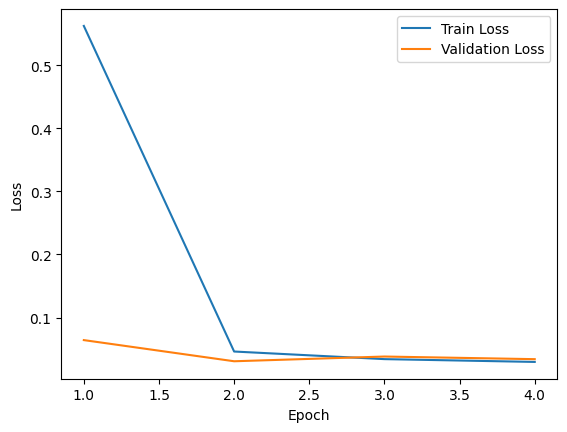

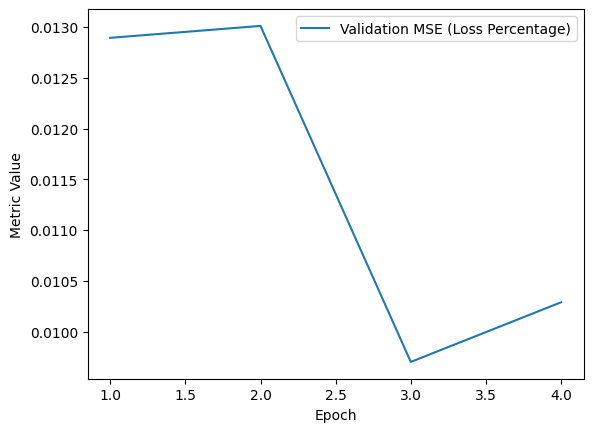

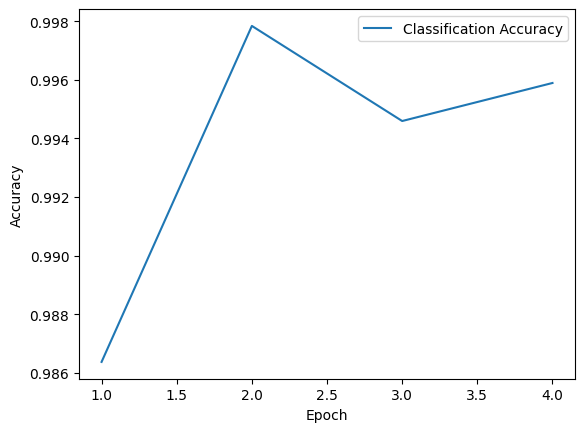

In [15]:
train(model, train_dataloader, validation_dataloader, num_epochs=4)

In [16]:
model_improved = ImprovedCombinedCNN(num_regression_outputs=2, num_classification_classes=6)


Epoch 1/4: 100%|██████████| 506/506 [20:35<00:00,  2.44s/batch, train_loss=0.137]


Epoch 1/4, Train Loss: 0.1374, Validation Loss: 0.0359,               Validation MSE (Loss Percentage): 0.0144,               Classification Accuracy: 0.9961


Epoch 2/4: 100%|██████████| 506/506 [23:17<00:00,  2.76s/batch, train_loss=0.0317]


Epoch 2/4, Train Loss: 0.0317, Validation Loss: 0.0223,               Validation MSE (Loss Percentage): 0.0106,               Classification Accuracy: 0.9978


Epoch 3/4: 100%|██████████| 506/506 [22:12<00:00,  2.63s/batch, train_loss=0.0282]


Epoch 3/4, Train Loss: 0.0283, Validation Loss: 0.0204,               Validation MSE (Loss Percentage): 0.0087,               Classification Accuracy: 0.9970


Epoch 4/4: 100%|██████████| 506/506 [25:03<00:00,  2.97s/batch, train_loss=0.0278]


Epoch 4/4, Train Loss: 0.0278, Validation Loss: 0.0169,               Validation MSE (Loss Percentage): 0.0124,               Classification Accuracy: 0.9985


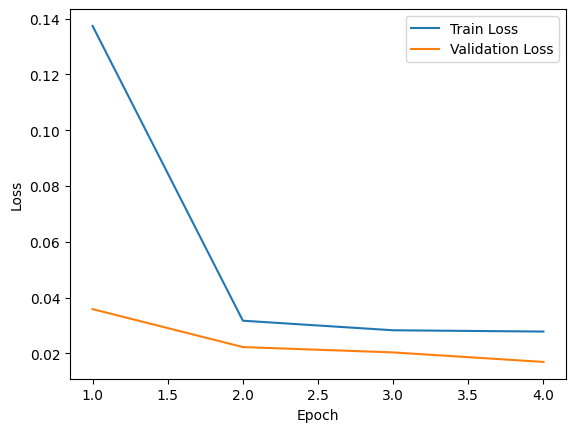

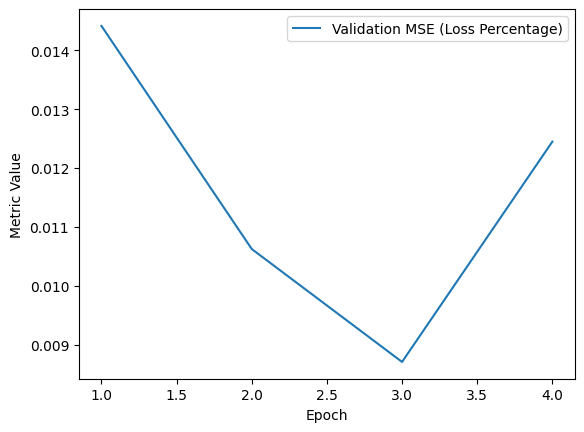

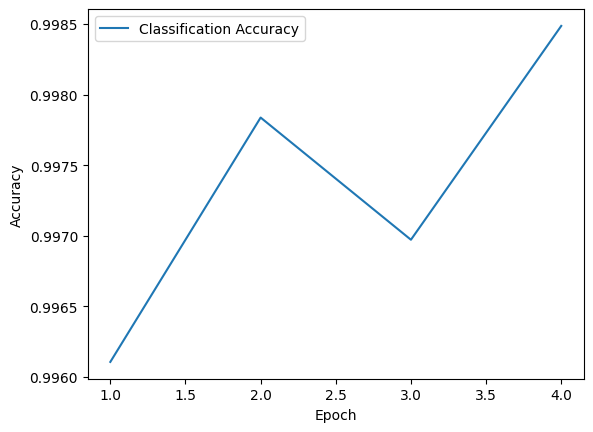

In [17]:
train(model_improved, train_dataloader, validation_dataloader, num_epochs=4)

#### Test


In [18]:
def test(model, test_dataloader):

    model.eval()
    criterion_regression = nn.MSELoss()
    criterion_classification = nn.CrossEntropyLoss()

    all_regression_targets = []
    all_regression_predictions = []
    all_classification_targets = []
    all_classification_predictions = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs)

            # Separate regression and classification targets
            regression_targets = targets['regression']
            classification_targets = targets['classification']

            # Calculate regression loss
            regression_loss = criterion_regression(outputs['regression'], regression_targets)

            # Calculate classification loss
            classification_loss = criterion_classification(outputs['classification'], classification_targets)

            all_regression_targets.extend(regression_targets.cpu().numpy())
            all_regression_predictions.extend(outputs['regression'].cpu().numpy())

            all_classification_targets.extend(classification_targets.cpu().numpy())
            _, predicted_classes = torch.max(outputs['classification'], 1)
            all_classification_predictions.extend(predicted_classes.cpu().numpy())

    # Regression metrics
    all_regression_targets = np.array(all_regression_targets)
    all_regression_predictions = np.array(all_regression_predictions)

    mse_loss_percentage = mean_squared_error(all_regression_targets[:, 0], all_regression_predictions[:, 0])
    mae_loss_percentage = mean_absolute_error(all_regression_targets[:, 0], all_regression_predictions[:, 0])

    mse_irradiance_level = mean_squared_error(all_regression_targets[:, 1], all_regression_predictions[:, 1])
    mae_irradiance_level = mean_absolute_error(all_regression_targets[:, 1], all_regression_predictions[:, 1])

    # Classification metrics
    all_classification_targets = np.array(all_classification_targets)
    all_classification_predictions = np.array(all_classification_predictions)

    accuracy = accuracy_score(all_classification_targets, all_classification_predictions)
    classification_rep = classification_report(all_classification_targets, all_classification_predictions)

    print(f'Regression Metrics (Loss Percentage): MSE: {mse_loss_percentage:.4f}, MAE: {mae_loss_percentage:.4f}')
    print(f'Regression Metrics (Irradiance Level): MSE: {mse_irradiance_level:.4f}, MAE: {mae_irradiance_level:.4f}')
    print(f'Classification Metrics: Accuracy: {accuracy:.4f}')
    print('Classification Report:\n', classification_rep)



In [19]:
test(model, test_dataloader)

Regression Metrics (Loss Percentage): MSE: 0.0116, MAE: 0.0684
Regression Metrics (Irradiance Level): MSE: 0.0140, MAE: 0.0910
Classification Metrics: Accuracy: 0.9957
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       0.99      1.00      0.99       639
           2       1.00      1.00      1.00       158
           3       1.00      0.97      0.99       345
           4       1.00      1.00      1.00       962
           5       1.00      1.00      1.00       132

    accuracy                           1.00      2312
   macro avg       1.00      1.00      1.00      2312
weighted avg       1.00      1.00      1.00      2312



In [20]:
test(model_improved, test_dataloader)

Regression Metrics (Loss Percentage): MSE: 0.0105, MAE: 0.0642
Regression Metrics (Irradiance Level): MSE: 0.0133, MAE: 0.0850
Classification Metrics: Accuracy: 0.9996
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00       639
           2       1.00      1.00      1.00       158
           3       1.00      1.00      1.00       345
           4       1.00      1.00      1.00       962
           5       1.00      1.00      1.00       132

    accuracy                           1.00      2312
   macro avg       1.00      1.00      1.00      2312
weighted avg       1.00      1.00      1.00      2312



### Visualizing Predictions

#### Visualize the first CNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

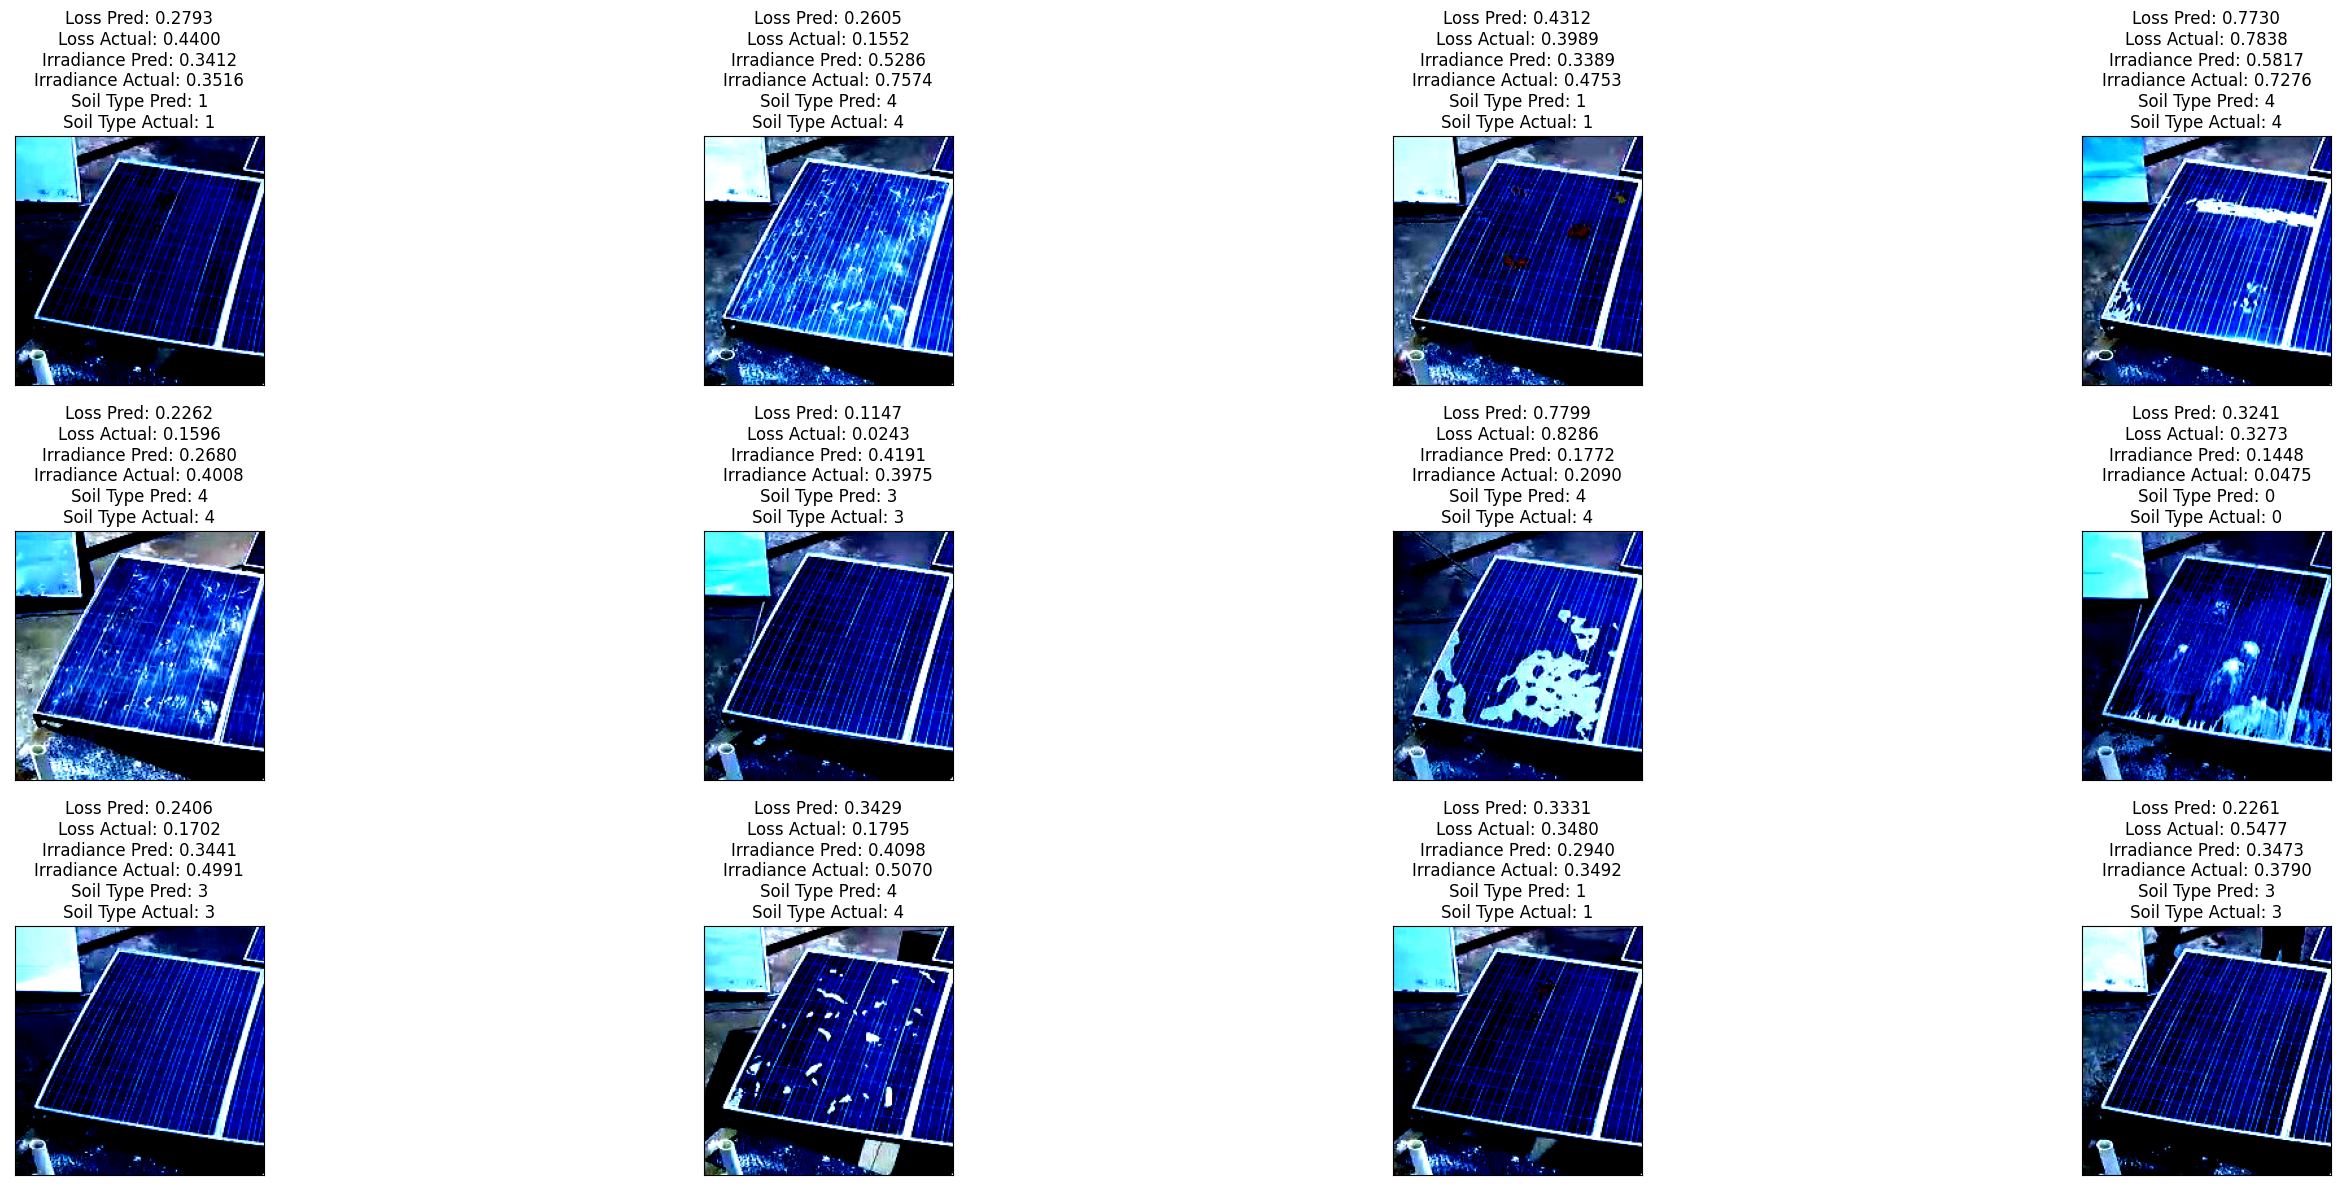

In [21]:
for images, targets in test_dataloader:
    break

outputs = model(images)
predictions_regression = outputs['regression'].detach().numpy()
predictions_classification = outputs['classification'].detach().numpy()

images = images.numpy()

fig = plt.figure(figsize=(30, 12))  # Increase the width and height for larger images

for idx in range(12):
    ax = fig.add_subplot(3, 4, idx + 1, xticks=[], yticks=[])  # 3 rows, 4 columns for 12 images
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))  # (batch_size, channels, height, width) format

    # Set the title with predicted and true values for regression targets
    pred_loss_percentage = predictions_regression[idx][0]
    pred_irradiance_level = predictions_regression[idx][1]

    true_loss_percentage = targets['regression'][idx][0].item()
    true_irradiance_level = targets['regression'][idx][1].item()

    # Get predicted and true soil types
    pred_soil_type = np.argmax(predictions_classification[idx])
    true_soil_type = targets['classification'][idx].item()

    ax.set_title('Loss Pred: {:.4f}\nLoss Actual: {:.4f}\nIrradiance Pred: {:.4f}\nIrradiance Actual: {:.4f}\n'
                 'Soil Type Pred: {}\nSoil Type Actual: {}'.format(
                     pred_loss_percentage, true_loss_percentage, pred_irradiance_level, true_irradiance_level,
                     pred_soil_type, true_soil_type))

plt.tight_layout()
plt.show()



#### Visualize the improved CNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

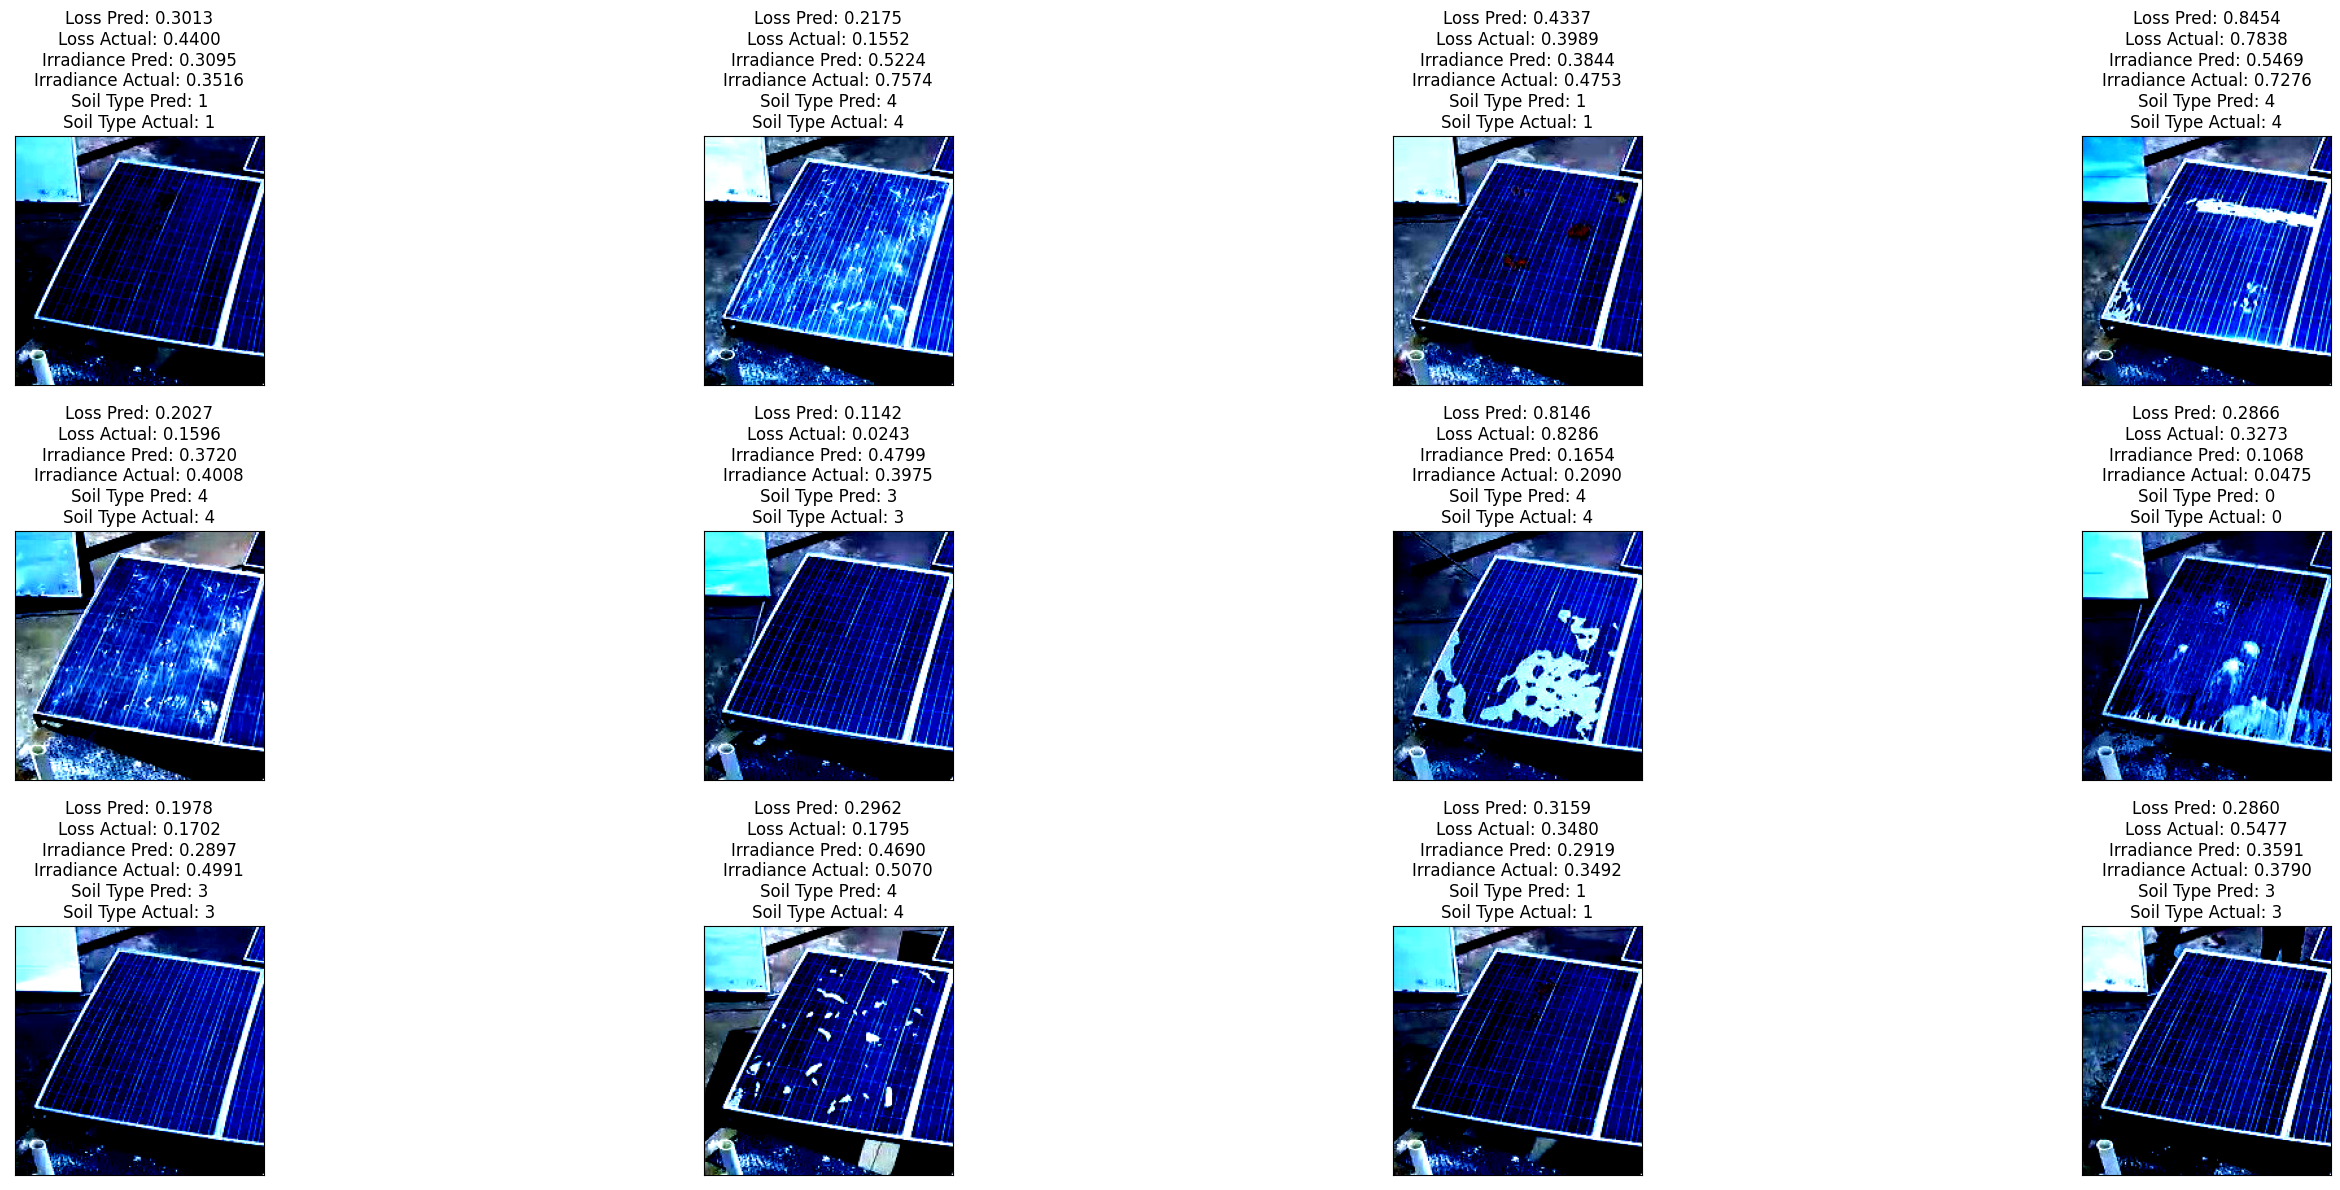

In [22]:
for images, targets in test_dataloader:
    break

outputs = model_improved(images)
predictions_regression = outputs['regression'].detach().numpy()
predictions_classification = outputs['classification'].detach().numpy()

images = images.numpy()

fig = plt.figure(figsize=(30, 12))  # Increase the width and height for larger images

for idx in range(12):
    ax = fig.add_subplot(3, 4, idx + 1, xticks=[], yticks=[])  # 3 rows, 4 columns for 12 images
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))  # (batch_size, channels, height, width) format

    # Set the title with predicted and true values for regression targets
    pred_loss_percentage = predictions_regression[idx][0]
    pred_irradiance_level = predictions_regression[idx][1]

    true_loss_percentage = targets['regression'][idx][0].item()
    true_irradiance_level = targets['regression'][idx][1].item()

    # Get predicted and true soil types
    pred_soil_type = np.argmax(predictions_classification[idx])
    true_soil_type = targets['classification'][idx].item()

    ax.set_title('Loss Pred: {:.4f}\nLoss Actual: {:.4f}\nIrradiance Pred: {:.4f}\nIrradiance Actual: {:.4f}\n'
                 'Soil Type Pred: {}\nSoil Type Actual: {}'.format(
                     pred_loss_percentage, true_loss_percentage, pred_irradiance_level, true_irradiance_level,
                     pred_soil_type, true_soil_type))

plt.tight_layout()
plt.show()